In [140]:
import pandas as pd
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
# No keys required for crypto data
client = CryptoHistoricalDataClient()

In [142]:
# Creating request object
tf = TimeFrame(amount=1, unit=TimeFrameUnit.Hour)

request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD"],
  timeframe=tf,
  start=datetime(2025, 5, 1),
  end=datetime(2025, 5, 27)
)

In [144]:
# Retrieve daily bars for Bitcoin in a DataFrame and printing it
btc_bars = client.get_crypto_bars(request_params)
btc_df = btc_bars.df

In [146]:



#data.set_index('timestamp', inplace=True)

# Farbe der Candle
btc_df['color'] = btc_df.apply(lambda row: 'green' if row['close'] > row['open'] else 'red', axis=1)



In [147]:

# Logik zur Erkennung von Strong Highs und Strong Lows
structure = []
candidate_WH = None
candidate_WL = None
candidate_SH = None
candidate_SL = None
up_count = 0
down_count = 0

for i in range(1, len(btc_df)):
    prev = btc_df.iloc[i - 1]
    curr = btc_df.iloc[i]

    # Zähle gleiche Farben
    if curr['color'] == 'green' and prev['color'] == 'green':
        up_count += 1
        down_count = 0
        # Prüfe auf potenzielles Hoch
        if curr['high'] > prev['high']:
            candidate_high = curr
    elif curr['color'] == 'red' and prev['color'] == 'red':
        down_count += 1
        up_count = 0
        # Prüfe auf potenzielles Tief
        if curr['low'] < prev['low']:
            candidate_low = curr
    else:
        up_count = 0
        down_count = 0

    # Bestätige Strong High
    if candidate_high is not None and curr['color'] == 'red' and prev['color'] == 'red':
        structure.append({'type': 'Strong High', 'time': candidate_high.name, 'price': candidate_high['high']})
        candidate_high = None

    # Bestätige Strong Low
    if candidate_low is not None and curr['color'] == 'green' and prev['color'] == 'green':
        #hier muss zusätzlich überprüfen ob das vorherige low 
        structure.append({'type': 'Strong Low', 'time': candidate_low.name, 'price': candidate_low['low']})
        candidate_low = None

# Ausgabe als DataFrame
structure_df = pd.DataFrame(structure)
print(structure_df)


            type                                  time          price
0    Strong High  (BTC/USD, 2025-05-01 10:00:00+00:00)   96402.900000
1     Strong Low  (BTC/USD, 2025-05-01 20:00:00+00:00)   96377.361000
2    Strong High  (BTC/USD, 2025-05-02 03:00:00+00:00)   97249.717000
3     Strong Low  (BTC/USD, 2025-05-02 05:00:00+00:00)   96036.945813
4    Strong High  (BTC/USD, 2025-05-02 12:00:00+00:00)   97223.655500
..           ...                                   ...            ...
112  Strong High  (BTC/USD, 2025-05-26 07:00:00+00:00)  110251.606000
113   Strong Low  (BTC/USD, 2025-05-26 10:00:00+00:00)  109587.033000
114  Strong High  (BTC/USD, 2025-05-26 12:00:00+00:00)  110086.651000
115   Strong Low  (BTC/USD, 2025-05-26 17:00:00+00:00)  108963.764500
116  Strong High  (BTC/USD, 2025-05-26 20:00:00+00:00)  109643.400000

[117 rows x 3 columns]


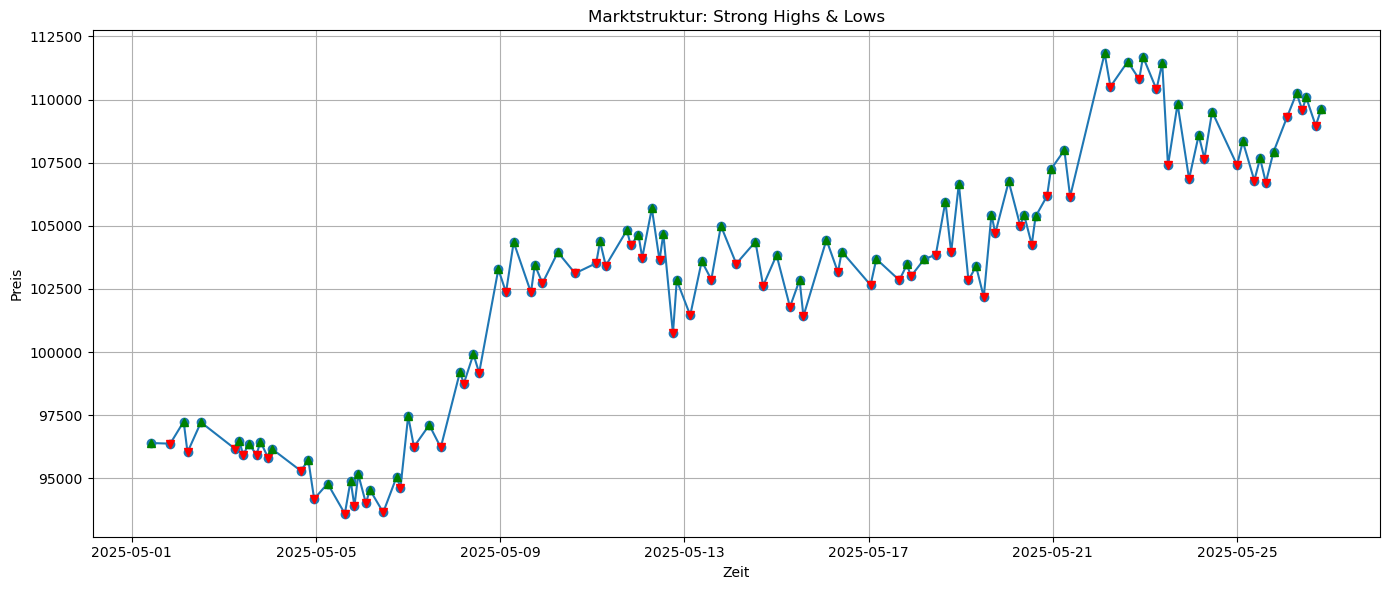

In [151]:


# Optional: Konvertiere Zeitstempel, falls nötig
structure_df['time'] = pd.to_datetime(structure_df['time'].apply(lambda x: x[1]))  # extrahiere Zeit aus Tuple
#structure_df['symbol'] = structure_df['time'].apply(lambda x: x[0])  # extrahiere Symbol, falls gebraucht

structure_df['time'] = pd.to_datetime(structure_df['time'])  # falls noch nötig

structure_df_sorted = structure_df.sort_values('time')

plt.figure(figsize=(14, 6))
plt.plot(structure_df_sorted['time'], structure_df_sorted['price'], marker='o', linestyle='-')

# Labels
plt.title("Marktstruktur: Strong Highs & Lows")
plt.xlabel("Zeit")
plt.ylabel("Preis")
plt.grid(True)

# Optional: farbige Marker je nach Typ
for i, row in structure_df_sorted.iterrows():
    if row['type'] == 'Strong High':
        plt.plot(row['time'], row['price'], marker='^', color='green')
    elif row['type'] == 'Strong Low':
        plt.plot(row['time'], row['price'], marker='v', color='red')

plt.tight_layout()
plt.show()


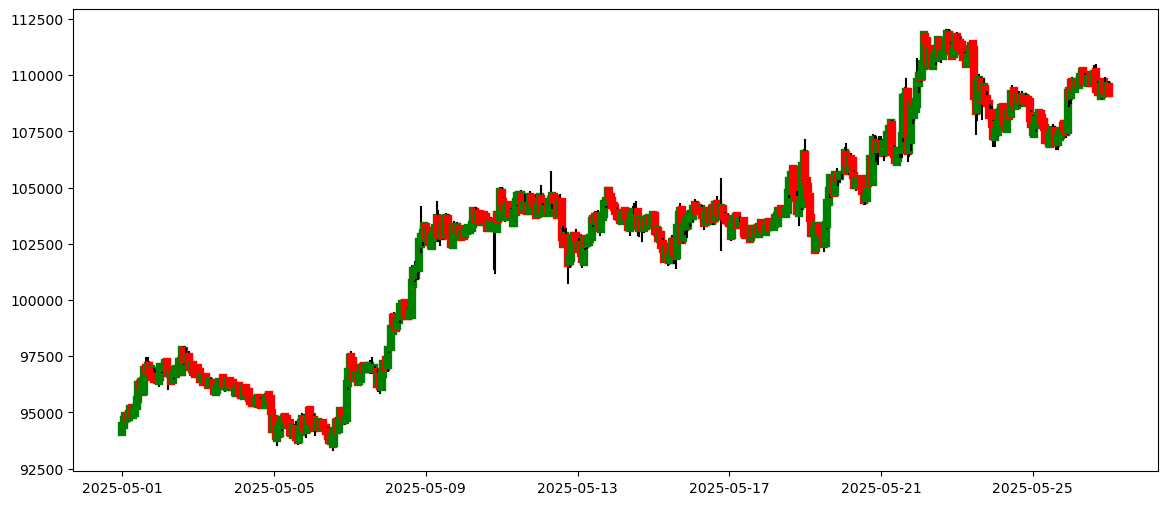

In [153]:





btc_df = btc_df.reset_index()
# Plot vorbereiten
fig, ax = plt.subplots(figsize=(14, 6))

for idx, row in btc_df.iterrows():
    color = 'green' if row['close'] >= row['open'] else 'red'
    ax.plot([row['timestamp'], row['timestamp']], [row['low'], row['high']], color='black')  # Docht
    ax.plot([row['timestamp'], row['timestamp']], [row['open'], row['close']], color=color, linewidth=6)  # Körper


In [155]:
print(btc_df.columns)
print(structure_df.columns)

Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'trade_count', 'vwap', 'color'],
      dtype='object')
Index(['type', 'time', 'price'], dtype='object')


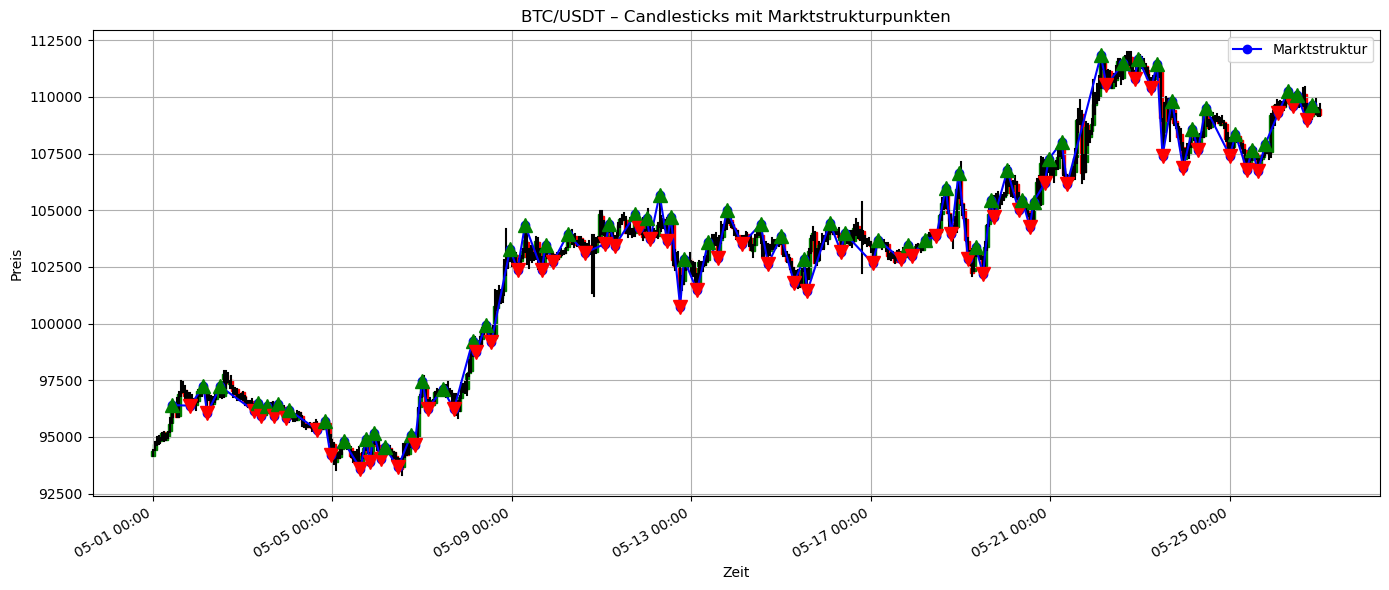

In [162]:
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])  # Sicherheit

# Strukturpunkte 'time' aufbereiten (Tuple entpacken falls nötig)
structure_df['time'] = structure_df['time'].apply(lambda x: x[1] if isinstance(x, tuple) else x)
structure_df['time'] = pd.to_datetime(structure_df['time'])

# Schritt 2: Plot aufsetzen
fig, ax = plt.subplots(figsize=(14, 6))

# Breite der Kerze in Zeit
candle_width = pd.Timedelta(hours=2)  # bei 15-Minuten-Candles etwas kleiner für Abstand

# Schritt 3: Candlesticks zeichnen
for idx, row in btc_df.iterrows():
    color = 'green' if row['close'] >= row['open'] else 'red'
    lower = min(row['open'], row['close'])
    height = abs(row['close'] - row['open'])

    # Rechteck für Candle-Body
    rect = mpatches.Rectangle(
        (row['timestamp'] - candle_width / 2, lower),  # (x, y) Startpunkt
        candle_width,  # Breite
        height,        # Höhe
        color=color
    )
    ax.add_patch(rect)

    # Docht (Wick)
    ax.plot([row['timestamp'], row['timestamp']], [row['low'], row['high']], color='black')

# Schritt 4: Strukturpunkte als Linie verbinden
structure_sorted = structure_df.sort_values('time')
ax.plot(structure_sorted['time'], structure_sorted['price'], linestyle='-', marker='o', color='blue', label='Marktstruktur')

# Schritt 5: Strukturpunkte markieren
for _, row in structure_sorted.iterrows():
    if row['type'] == 'Strong High':
        ax.plot(row['time'], row['price'], marker='^', color='green', markersize=10)
    elif row['type'] == 'Strong Low':
        ax.plot(row['time'], row['price'], marker='v', color='red', markersize=10)

# Schritt 6: Formatierungen
ax.set_title('BTC/USDT – Candlesticks mit Marktstrukturpunkten')
ax.set_xlabel('Zeit')
ax.set_ylabel('Preis')
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

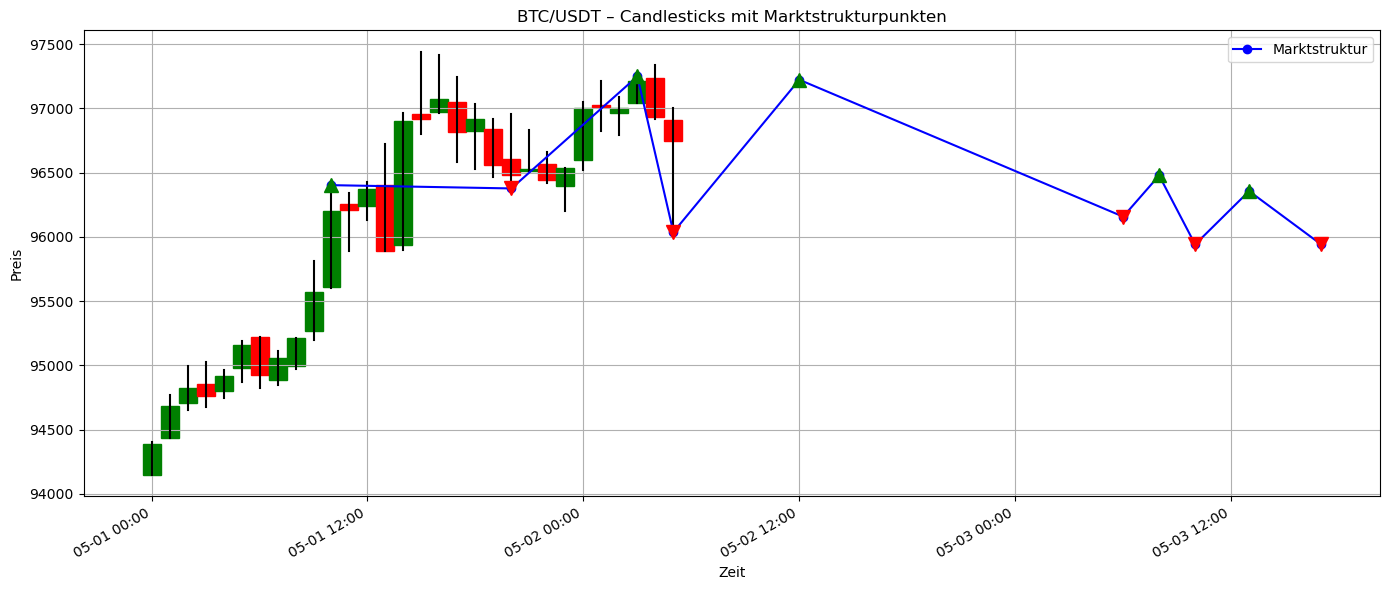

In [174]:
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])  # Sicherheit

# Strukturpunkte 'time' aufbereiten (Tuple entpacken falls nötig)
structure_df['time'] = structure_df['time'].apply(lambda x: x[1] if isinstance(x, tuple) else x)
structure_df['time'] = pd.to_datetime(structure_df['time'])

# Schritt 2: Plot aufsetzen
fig, ax = plt.subplots(figsize=(14, 6))

# Breite der Kerze in Zeit
candle_width = pd.Timedelta(hours=1)  # bei 15-Minuten-Candles etwas kleiner für Abstand

# Schritt 3: Candlesticks zeichnen
for idx, row in btc_df.head(30).iterrows():
    color = 'green' if row['close'] >= row['open'] else 'red'
    lower = min(row['open'], row['close'])
    height = abs(row['close'] - row['open'])

    # Rechteck für Candle-Body
    rect = mpatches.Rectangle(
        (row['timestamp'] - candle_width / 2, lower),  # (x, y) Startpunkt
        candle_width,  # Breite
        height,        # Höhe
        color=color
    )
    ax.add_patch(rect)

    # Docht (Wick)
    ax.plot([row['timestamp'], row['timestamp']], [row['low'], row['high']], color='black')

# Schritt 4: Strukturpunkte als Linie verbinden
structure_sorted = structure_df.head(10).sort_values('time')
ax.plot(structure_sorted['time'], structure_sorted['price'], linestyle='-', marker='o', color='blue', label='Marktstruktur')

# Schritt 5: Strukturpunkte markieren
for _, row in structure_sorted.head(10).iterrows():
    if row['type'] == 'Strong High':
        ax.plot(row['time'], row['price'], marker='^', color='green', markersize=10)
    elif row['type'] == 'Strong Low':
        ax.plot(row['time'], row['price'], marker='v', color='red', markersize=10)

# Schritt 6: Formatierungen
ax.set_title('BTC/USDT – Candlesticks mit Marktstrukturpunkten')
ax.set_xlabel('Zeit')
ax.set_ylabel('Preis')
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

In [176]:
print(btc_df.head(40))

     symbol                 timestamp          open          high  \
0   BTC/USD 2025-05-01 00:00:00+00:00  94146.569500  94407.102500   
1   BTC/USD 2025-05-01 01:00:00+00:00  94433.048000  94771.020000   
2   BTC/USD 2025-05-01 02:00:00+00:00  94710.350000  94995.700000   
3   BTC/USD 2025-05-01 03:00:00+00:00  94856.875000  95027.560000   
4   BTC/USD 2025-05-01 04:00:00+00:00  94801.747000  94967.020000   
5   BTC/USD 2025-05-01 05:00:00+00:00  94977.317500  95187.470000   
6   BTC/USD 2025-05-01 06:00:00+00:00  95219.585000  95219.585000   
7   BTC/USD 2025-05-01 07:00:00+00:00  94884.040000  95108.746500   
8   BTC/USD 2025-05-01 08:00:00+00:00  94998.460500  95216.465500   
9   BTC/USD 2025-05-01 09:00:00+00:00  95269.677000  95813.726000   
10  BTC/USD 2025-05-01 10:00:00+00:00  95612.239000  96402.900000   
11  BTC/USD 2025-05-01 11:00:00+00:00  96259.100000  96338.200000   
12  BTC/USD 2025-05-01 12:00:00+00:00  96242.836000  96425.000254   
13  BTC/USD 2025-05-01 13:00:00+00

In [108]:


# Ergebnisliste für bestätigte Strong Highs / Lows
structure = []

# Temporäre und letzte Zeichen
candidate_WH = None
candidate_WL = None
last_SH = None
last_WL = None

# Zähler für gleichfarbige Kerzen
up_count = 0
down_count = 0

# Temporäre Extrema
max_high = None
max_high_time = None
min_low = None
min_low_time = None

for i in range(1, len(btc_df)):
    prev = btc_df.iloc[i-1]
    curr = btc_df.iloc[i]

    # ————— Trendzählung & Extrema-Speicherung —————
    if curr['color'] == 'green':
        if prev['color'] == 'green':
            up_count += 1
            # neues lokales Hoch?
            if max_high is None or curr['high'] > max_high:
                max_high = curr['high']
                max_high_time = curr.name
        else:
            up_count = 1
            max_high = curr['high']
            max_high_time = curr.name
        down_count = 0
        # Tief-Temp zurücksetzen
        min_low = None
        min_low_time = None

    elif curr['color'] == 'red':
        if prev['color'] == 'red':
            down_count += 1
            # neues lokales Tief?
            if min_low is None or curr['low'] < min_low:
                min_low = curr['low']
                min_low_time = curr.name
        else:
            down_count = 1
            min_low = curr['low']
            min_low_time = curr.name
        up_count = 0
        # Hoch-Temp zurücksetzen
        max_high = None
        max_high_time = None

    else:
        # falls andere Farben oder NaN
        up_count = down_count = 0

    # ————— 1) Weak High erkennen —————
    if down_count == 2 and candidate_WH is None and max_high_time is not None:
        candidate_WH = {'time': max_high_time, 'price': max_high}

    # ————— 2) Conversion WH → SH & Weak Low anlegen —————
    if candidate_WH is not None and up_count == 2 and min_low_time is not None:
        # a) Weak Low zwischenspeichern
        candidate_WL = {'time': min_low_time, 'price': min_low}
        # b) WH nur dann zum SH machen, wenn es höher ist als das letzte SH
        if last_SH is None or candidate_WH['price'] > last_SH['price']:
            structure.append({
                'type':  'Strong High',
                'time':  candidate_WH['time'],
                'price': candidate_WH['price']
            })
            last_SH = candidate_WH
        # c) Reset WH
        candidate_WH = None

    # ————— 3) Weak Low überschreiben, falls tiefer (Replacement) —————
    if candidate_WL is not None and up_count == 2:
        new_low  = min_low
        new_time = min_low_time
        if last_WL is None or new_low < last_WL['price']:
            candidate_WL = {'time': new_time, 'price': new_low}
            last_WL = candidate_WL



In [110]:
print(structure)

[]


In [112]:
# ————— Ausgabe der bestätigten Strong Highs / Lows —————
structure_df = pd.DataFrame(structure)
print(structure_df)

Empty DataFrame
Columns: []
Index: []
